In [100]:
import numpy as np

### Hyperparametros

In [101]:
import ast

results = open("./../models/Glass_models/results.txt", "r")
results = results.readlines()
count = 0
results_dict = {}
for line in results:
    line = line.strip("\n")
    line_by_spaces = line.split(" ")
    if line_by_spaces[0] == "Batch":
        line_by_comas = line.split(",")
        settings = {}
        for item in line_by_comas:
            setting = item.strip(" ").split(":")
            settings[setting[0]] = float(setting[1].strip(" ")) 
        results_dict[count] = settings
    if line_by_spaces[0] == "Mean":
        results = line.strip("Mean performance of 5 folds:")
        results = ast.literal_eval(results)
        combined_results = {}
        for key in results:
            for value in results[key]:
                new_key = key + "_" + value
                combined_results[new_key] = results[key][value]
        results_dict[count] = results_dict[count] | combined_results
        count += 1

print(results_dict)
print(len(results_dict))

{0: {'Batch size': 8.0, 'Learning rate': 0.01, 'Batch size per image': 128.0, 'bbox_AP': 43.59177287300535, 'bbox_AP50': 65.92723719445313, 'bbox_AP75': 50.564413713358704, 'bbox_APs': 35.955233040506, 'bbox_APm': 55.56294957251437, 'bbox_APl': 51.11995391313924, 'bbox_AP-dark': 41.07340301444045, 'bbox_AP-light': 46.11014273157025, 'segm_AP': 15.390359177487673, 'segm_AP50': 46.43242921725746, 'segm_AP75': 3.275656821580698, 'segm_APs': 11.55860743408079, 'segm_APm': 31.76880301166441, 'segm_APl': 8.574257425742575, 'segm_AP-dark': 14.865414754390628, 'segm_AP-light': 15.915303600584718}, 1: {'Batch size': 8.0, 'Learning rate': 0.01, 'Batch size per image': 256.0, 'bbox_AP': 44.93520647887999, 'bbox_AP50': 67.21765291045446, 'bbox_AP75': 50.5832693802959, 'bbox_APs': 36.67491825725259, 'bbox_APm': 54.87714550595435, 'bbox_APl': 53.53692361775451, 'bbox_AP-dark': 39.945840910336834, 'bbox_AP-light': 49.924572047423155, 'segm_AP': 15.829880521556936, 'segm_AP50': 48.26733100161067, 'seg

In [102]:
print(results_dict[12])

{'Batch size': 16.0, 'Learning rate': 0.001, 'Batch size per image': 128.0, 'bbox_AP': 43.166624745925446, 'bbox_AP50': 63.63430164658389, 'bbox_AP75': 49.74156317350856, 'bbox_APs': 34.92820138747817, 'bbox_APm': 54.09702821985816, 'bbox_APl': 51.16617479277433, 'bbox_AP-dark': 38.95898475789518, 'bbox_AP-light': 47.37426473395571, 'segm_AP': 16.0910902045605, 'segm_AP50': 45.58216415332865, 'segm_AP75': 4.613027771852841, 'segm_APs': 11.924240566712044, 'segm_APm': 33.15265385828469, 'segm_APl': 8.125412541254125, 'segm_AP-dark': 15.093406342588224, 'segm_AP-light': 17.08877406653277}


In [103]:
import pandas as pd

df = pd.DataFrame.from_dict(results_dict, orient='index')
print(df)
print(df.shape)

    Batch size  Learning rate  Batch size per image    bbox_AP  bbox_AP50  \
0          8.0         0.0100                 128.0  43.591773  65.927237   
1          8.0         0.0100                 256.0  44.935206  67.217653   
2          8.0         0.0100                 512.0  46.684244  68.567989   
3          8.0         0.0010                 128.0  41.672199  61.979261   
4          8.0         0.0010                 256.0  43.013015  63.402731   
5          8.0         0.0010                 512.0  42.117904  61.548173   
6          8.0         0.0001                 128.0  29.794954  47.921726   
7          8.0         0.0001                 256.0  28.415329  47.210647   
8          8.0         0.0001                 512.0  20.811372  38.929418   
9         16.0         0.0100                 128.0  47.417654  69.580069   
10        16.0         0.0100                 256.0  47.135718  69.004608   
11        16.0         0.0100                 512.0  47.512305  67.934452   

In [104]:
df_sorted = df.sort_values(by=['bbox_AP','segm_AP'], ascending=False)
df_sorted.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,bbox_AP50,bbox_AP75,bbox_APs,bbox_APm,bbox_APl,bbox_AP-dark,bbox_AP-light,segm_AP,segm_AP50,segm_AP75,segm_APs,segm_APm,segm_APl,segm_AP-dark,segm_AP-light
11,16.0,0.01,512.0,47.512305,67.934452,54.764002,39.548815,57.688203,56.009044,43.295286,51.729324,17.986477,54.085936,4.597440,12.678896,31.522979,11.742574,16.672235,19.300720
9,16.0,0.01,128.0,47.417654,69.580069,55.111504,37.990275,58.911611,57.470876,43.563367,51.271940,17.200396,51.008179,3.885954,12.843699,33.192960,9.811881,15.273563,19.127229
10,16.0,0.01,256.0,47.135718,69.004608,53.993935,38.574433,58.171946,54.149999,43.173055,51.098381,17.392221,50.265126,4.236276,12.021098,34.211788,9.069307,15.247958,19.536483
2,8.0,0.01,512.0,46.684244,68.567989,54.005698,39.241959,56.730675,52.578142,41.210948,52.157539,18.142083,51.803926,4.722612,13.227040,32.253647,11.292904,15.179671,21.104495
1,8.0,0.01,256.0,44.935206,67.217653,50.583269,36.674918,54.877146,53.536924,39.945841,49.924572,15.829881,48.267331,3.144147,11.038798,32.664304,8.089109,13.322027,18.337734


The best models are 49 and 38, however performance is realy close and the difference is not super significant. We will need to further investigate the trends to see which one is better.

In [105]:
reduces_df = df[['Batch size', 'Learning rate', 'Batch size per image','bbox_AP', 'segm_AP']]
reduces_df.head()

,Batch size,Learning rate,Batch size per image,bbox_AP,segm_AP
0,8.0,0.010,128.0,43.591773,15.390359
1,8.0,0.010,256.0,44.935206,15.829881
2,8.0,0.010,512.0,46.684244,18.142083
3,8.0,0.001,128.0,41.672199,14.897699
4,8.0,0.001,256.0,43.013015,14.455119


In [106]:
grouped_bs = reduces_df.groupby('Batch size')
group = grouped_bs.get_group(8.0)
grouped_lr = group.groupby('Learning rate')
print(grouped_lr.head())

   Batch size  Learning rate  Batch size per image    bbox_AP    segm_AP
0         8.0         0.0100                 128.0  43.591773  15.390359
1         8.0         0.0100                 256.0  44.935206  15.829881
2         8.0         0.0100                 512.0  46.684244  18.142083
3         8.0         0.0010                 128.0  41.672199  14.897699
4         8.0         0.0010                 256.0  43.013015  14.455119
5         8.0         0.0010                 512.0  42.117904  13.531501
6         8.0         0.0001                 128.0  29.794954   8.522630
7         8.0         0.0001                 256.0  28.415329   8.134109
8         8.0         0.0001                 512.0  20.811372   6.969729


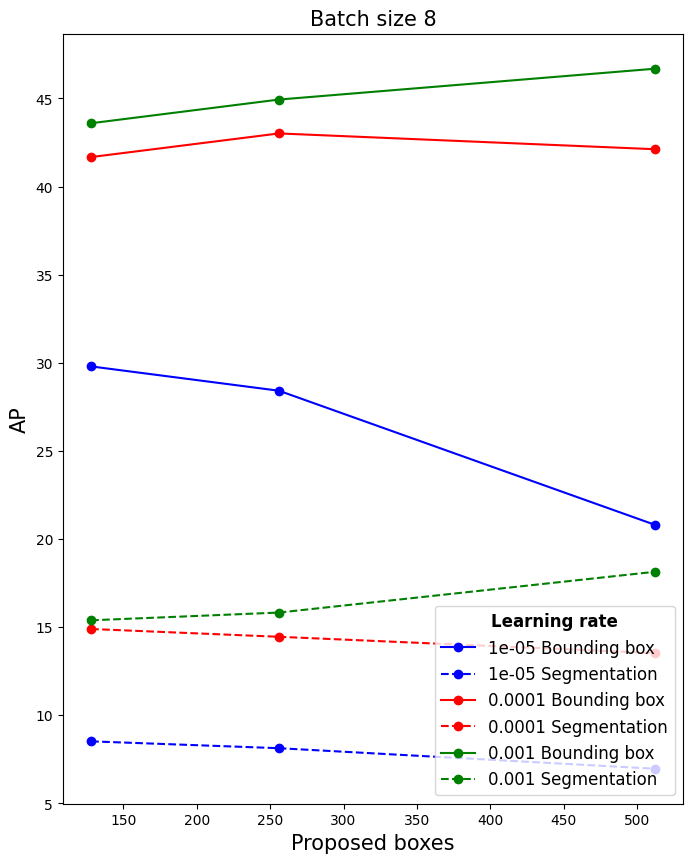

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot for batch size 8
fig, ax = plt.subplots(figsize=(8, 10))

line_styles = ['-', '--']
labels = ['bbox_AP', 'segm_AP']
colors = ['blue', 'red', 'green']

for j, (key_lr, group_lr) in enumerate(grouped_lr):
    for k, metric in enumerate([group_lr['bbox_AP'], group_lr['segm_AP']]):
        ax.plot(group_lr['Batch size per image'], metric, marker='o', linestyle=line_styles[k], label=f'{key_lr} {labels[k]}', color=colors[j])
ax.set_title('Batch size 8', fontsize=15)
ax.set_xlabel('Proposed boxes', fontsize=15)
ax.set_ylabel('AP', fontsize=15)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, ['1e-05 Bounding box', '1e-05 Segmentation', '0.0001 Bounding box', '0.0001 Segmentation', '0.001 Bounding box', '0.001 Segmentation'], loc='lower right', title='Learning rate', fontsize='large')
legend.get_title().set_fontsize('large')
legend.get_title().set_fontweight('bold')

plt.show()




In [108]:
group = grouped_bs.get_group(16.0)
grouped_lr = group.groupby('Learning rate')
print(grouped_lr.head())

    Batch size  Learning rate  Batch size per image    bbox_AP    segm_AP
9         16.0         0.0100                 128.0  47.417654  17.200396
10        16.0         0.0100                 256.0  47.135718  17.392221
11        16.0         0.0100                 512.0  47.512305  17.986477
12        16.0         0.0010                 128.0  43.166625  16.091090
13        16.0         0.0010                 256.0  44.536538  14.941678
14        16.0         0.0010                 512.0  42.449129  14.977607
15        16.0         0.0001                 128.0  30.321920   8.955534
16        16.0         0.0001                 256.0  27.839386   7.653886
17        16.0         0.0001                 512.0  21.032390   7.241761


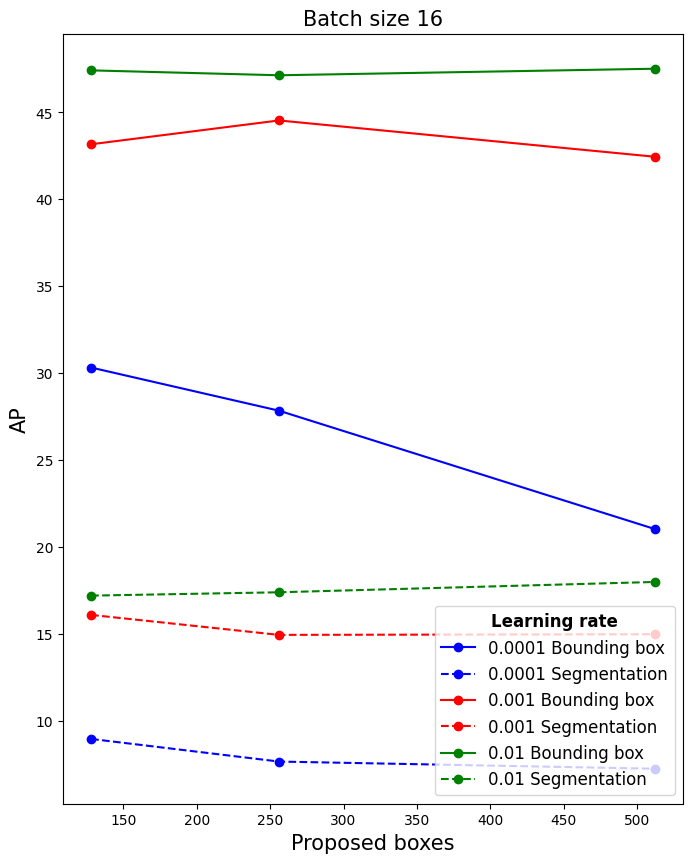

In [109]:
# Plot for batch size 16
fig, ax = plt.subplots(figsize=(8, 10))


line_styles = ['-', '--']
labels = ['bbox_AP', 'segm_AP']
colors = ['blue', 'red', 'green']

for j, (key_lr, group_lr) in enumerate(grouped_lr):
    for k, metric in enumerate([group_lr['bbox_AP'], group_lr['segm_AP']]):
        ax.plot(group_lr['Batch size per image'], metric, marker='o', linestyle=line_styles[k], label=f'{key_lr} {labels[k]}', color=colors[j])
ax.set_title('Batch size 16', fontsize=15)
ax.set_xlabel('Proposed boxes', fontsize=15)
ax.set_ylabel('AP', fontsize=15)

handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, ['0.0001 Bounding box', '0.0001 Segmentation', '0.001 Bounding box', '0.001 Segmentation', '0.01 Bounding box', '0.01 Segmentation'], loc='lower right', title='Learning rate', fontsize='large')
legend.get_title().set_fontsize('large')
legend.get_title().set_fontweight('bold')

plt.show()

The most relevant graphs are the ones with batch size of 6,8,10 as they yield the best results, more particularly 8 and 10. From 8 and 10 the same tendeny related to tuhe learning reate apear, as it shows that the best learning rate is 0.001. Within this lr, there are same similarities within the bspi, as bs=8.0 the best bs is 256 and higher value gets way worse results, and lower also worst but less significant. For bs=10.0 the best bs is 128, and the same trend is observed. So the ideal bspi looks between 128 and 256.

### Folds

In [110]:
import re

def get_results(data):
    keys = ["bbox_AP", "segm_AP"]
    results = {}
    matches = re.findall(r'{.*?}', data)
    for i,match in enumerate(matches):
        match = ast.literal_eval(match)
        results[keys[i]] = match
    return results

In [111]:
results = open("./../models/Glass_models/results.txt", "r")
results = results.readlines()
count = 0
data_dict = {}

for i, line in enumerate(results):
    line = line.strip("\n")
    if line == str(count):
        data_list = results[i+3:i+8]
        data_len = len(data_list)
        data = [d.split("OrderedDict")[1] for d in data_list]
        results_to_dict = [get_results(d) for d in data]
        fold_dict = {}
        for i, r in enumerate(results_to_dict):
            fold_dict[i] = r
        data_dict[count] = fold_dict
        count += 1

print(data_dict)

{0: {0: {'bbox_AP': {'AP': 38.36160836637298, 'AP50': 62.79320568211541, 'AP75': 41.294693847527654, 'APs': 33.92194125659601, 'APm': 52.21178556957964, 'APl': 41.782747865772485, 'AP-dark': 38.183289675642996, 'AP-light': 38.53992705710297}, 'segm_AP': {'AP': 15.26835309953306, 'AP50': 43.9055045902179, 'AP75': 5.025430319368716, 'APs': 12.84409539838552, 'APm': 32.70172610771327, 'APl': 10.099009900990099, 'AP-dark': 11.276970302824298, 'AP-light': 19.25973589624182}}, 1: {'bbox_AP': {'AP': 49.49465463828, 'AP50': 70.24002565245839, 'AP75': 60.29494899828747, 'APs': 39.02655642609197, 'APm': 60.53329922229147, 'APl': 63.51679108490488, 'AP-dark': 46.356603906480515, 'AP-light': 52.63270537007947}, 'segm_AP': {'AP': 18.21021239986325, 'AP50': 52.51494079284898, 'AP75': 2.294710123684909, 'APs': 13.099721702778721, 'APm': 32.43378021985333, 'APl': 11.287128712871288, 'AP-dark': 20.616764639179394, 'AP-light': 15.8036601605471}}, 2: {'bbox_AP': {'AP': 41.07479039081262, 'AP50': 62.14953

In [112]:
data_dict_unified = {}
for count in data_dict:
    for fold in data_dict[count]:
        for value in data_dict[count][fold]:
            for metric in data_dict[count][fold][value]:
                new_key = value + "_" + metric
                if count not in data_dict_unified:
                    data_dict_unified[count] = {}
                if fold not in data_dict_unified[count]:
                    data_dict_unified[count][fold] = {}
                data_dict_unified[count][fold][new_key] = data_dict[count][fold][value][metric]

print(data_dict_unified)

{0: {0: {'bbox_AP_AP': 38.36160836637298, 'bbox_AP_AP50': 62.79320568211541, 'bbox_AP_AP75': 41.294693847527654, 'bbox_AP_APs': 33.92194125659601, 'bbox_AP_APm': 52.21178556957964, 'bbox_AP_APl': 41.782747865772485, 'bbox_AP_AP-dark': 38.183289675642996, 'bbox_AP_AP-light': 38.53992705710297, 'segm_AP_AP': 15.26835309953306, 'segm_AP_AP50': 43.9055045902179, 'segm_AP_AP75': 5.025430319368716, 'segm_AP_APs': 12.84409539838552, 'segm_AP_APm': 32.70172610771327, 'segm_AP_APl': 10.099009900990099, 'segm_AP_AP-dark': 11.276970302824298, 'segm_AP_AP-light': 19.25973589624182}, 1: {'bbox_AP_AP': 49.49465463828, 'bbox_AP_AP50': 70.24002565245839, 'bbox_AP_AP75': 60.29494899828747, 'bbox_AP_APs': 39.02655642609197, 'bbox_AP_APm': 60.53329922229147, 'bbox_AP_APl': 63.51679108490488, 'bbox_AP_AP-dark': 46.356603906480515, 'bbox_AP_AP-light': 52.63270537007947, 'segm_AP_AP': 18.21021239986325, 'segm_AP_AP50': 52.51494079284898, 'segm_AP_AP75': 2.294710123684909, 'segm_AP_APs': 13.099721702778721, 

In [113]:
data_df = pd.concat({(i,j): pd.DataFrame(data_dict_unified[i][j], index=[0]) for i in data_dict_unified.keys() 
                for j in data_dict_unified[i].keys()}, axis=0)

# Reset the index
data_df.reset_index(inplace=True)

# Rename the columns
data_df.columns = ['OuterKey', 'InnerKey'] + list(data_df.columns[2:])
data_df = data_df.drop(columns=["level_2"])

# Print the DataFrame
data_df.head()

,OuterKey,InnerKey,bbox_AP_AP,bbox_AP_AP50,bbox_AP_AP75,bbox_AP_APs,bbox_AP_APm,bbox_AP_APl,bbox_AP_AP-dark,bbox_AP_AP-light,segm_AP_AP,segm_AP_AP50,segm_AP_AP75,segm_AP_APs,segm_AP_APm,segm_AP_APl,segm_AP_AP-dark,segm_AP_AP-light
0,0,0,38.361608,62.793206,41.294694,33.921941,52.211786,41.782748,38.183290,38.539927,15.268353,43.905505,5.025430,12.844095,32.701726,10.099010,11.276970,19.259736
1,0,1,49.494655,70.240026,60.294949,39.026556,60.533299,63.516791,46.356604,52.632705,18.210212,52.514941,2.294710,13.099722,32.433780,11.287129,20.616765,15.803660
2,0,2,41.074790,62.149534,47.309632,34.704747,50.737908,42.144889,34.066740,48.082840,14.291103,44.107804,3.524922,9.323425,30.314711,5.396040,13.576417,15.005789
3,0,3,47.702759,71.187196,58.354706,36.267465,59.431132,59.579625,47.622988,47.782531,17.948424,51.220519,4.301998,13.206969,34.684475,9.405941,18.138423,17.758425
4,0,4,41.325052,63.266224,45.568087,35.855456,54.900624,48.575716,39.137393,43.512710,11.233704,40.413377,1.231223,9.318826,28.709323,6.683168,10.718499,11.748908


In [114]:
data_df_bbox = data_df[['OuterKey', 'bbox_AP_AP']]
data_df_segm = data_df[['OuterKey', 'segm_AP_AP']]

In [115]:
grouped_data_bbox_df = data_df_bbox.groupby('OuterKey').describe()
grouped_data_segm_df = data_df_segm.groupby('OuterKey').describe()
grouped_data_bbox_df.head()
print(grouped_data_segm_df.shape)


(18, 8)


In [116]:
grouped_data_segm_df.head()

segm_AP_AP                                                        \
              count       mean       std        min        25%        50%   
OuterKey                                                                    
0               5.0  15.390359  2.872120  11.233704  14.291103  15.268353   
1               5.0  15.829881  1.622071  13.105083  15.677423  16.337149   
2               5.0  18.142083  3.444697  12.351533  18.281875  19.029283   
3               5.0  14.897699  2.224738  12.576405  13.176797  14.598387   
4               5.0  14.455119  1.700389  12.231576  13.336069  14.588213   

                                
                75%        max  
OuterKey                        
0         17.948424  18.210212  
1         16.940869  17.088879  
2         19.580239  21.467487  
3         16.085088  18.051816  
4         15.743075  16.376664

Text(0, 0.5, 'Value')

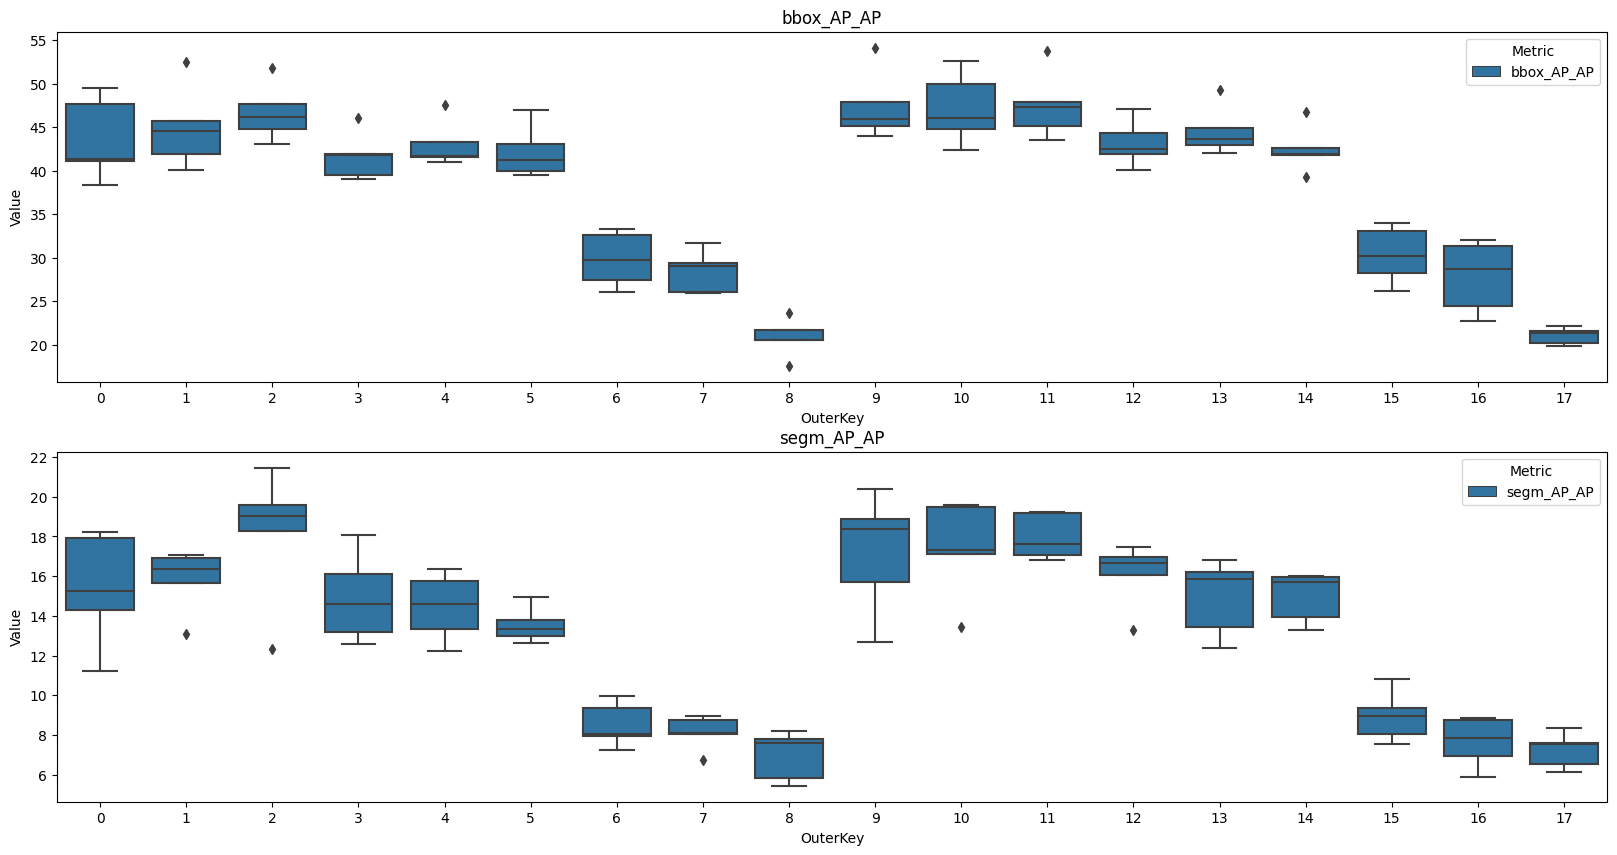

In [117]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

melted_bbox_df = data_df_bbox.melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
sns.boxplot(x='OuterKey', y='Value', data=melted_bbox_df, hue='Metric', ax=ax[0])
ax[0].set_title('bbox_AP_AP')
ax[0].set_xlabel('OuterKey')
ax[0].set_ylabel('Value')

melted_segm_df = data_df_segm.melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
sns.boxplot(x='OuterKey', y='Value', data=melted_segm_df, hue='Metric', ax=ax[1])
ax[1].set_title('segm_AP_AP')
ax[1].set_xlabel('OuterKey')
ax[1].set_ylabel('Value')

In [118]:
# Save a new df for sections of 12 rows of oute key of grouped_bbox_data_bbox_df
grouped_bbox_data_0_11 = grouped_data_bbox_df[0:9]
grouped_bbox_data_12_23 = grouped_data_bbox_df[9:18]
print(grouped_bbox_data_0_11.shape, grouped_bbox_data_12_23.shape)
grouped_bbox_data_0_11.head()

(9, 8) (9, 8)


bbox_AP_AP                                                        \
              count       mean       std        min        25%        50%   
OuterKey                                                                    
0               5.0  43.591773  4.758468  38.361608  41.074790  41.325052   
1               5.0  44.935206  4.774366  40.059704  41.886745  44.517976   
2               5.0  46.684244  3.338272  43.023189  44.808670  46.152721   
3               5.0  41.672199  2.768486  39.084258  39.523429  41.786456   
4               5.0  43.013015  2.666772  40.990213  41.507773  41.723947   

                                
                75%        max  
OuterKey                        
0         47.702759  49.494655  
1         45.703392  52.508215  
2         47.601555  51.835084  
3         41.904143  46.062707  
4         43.320948  47.522193

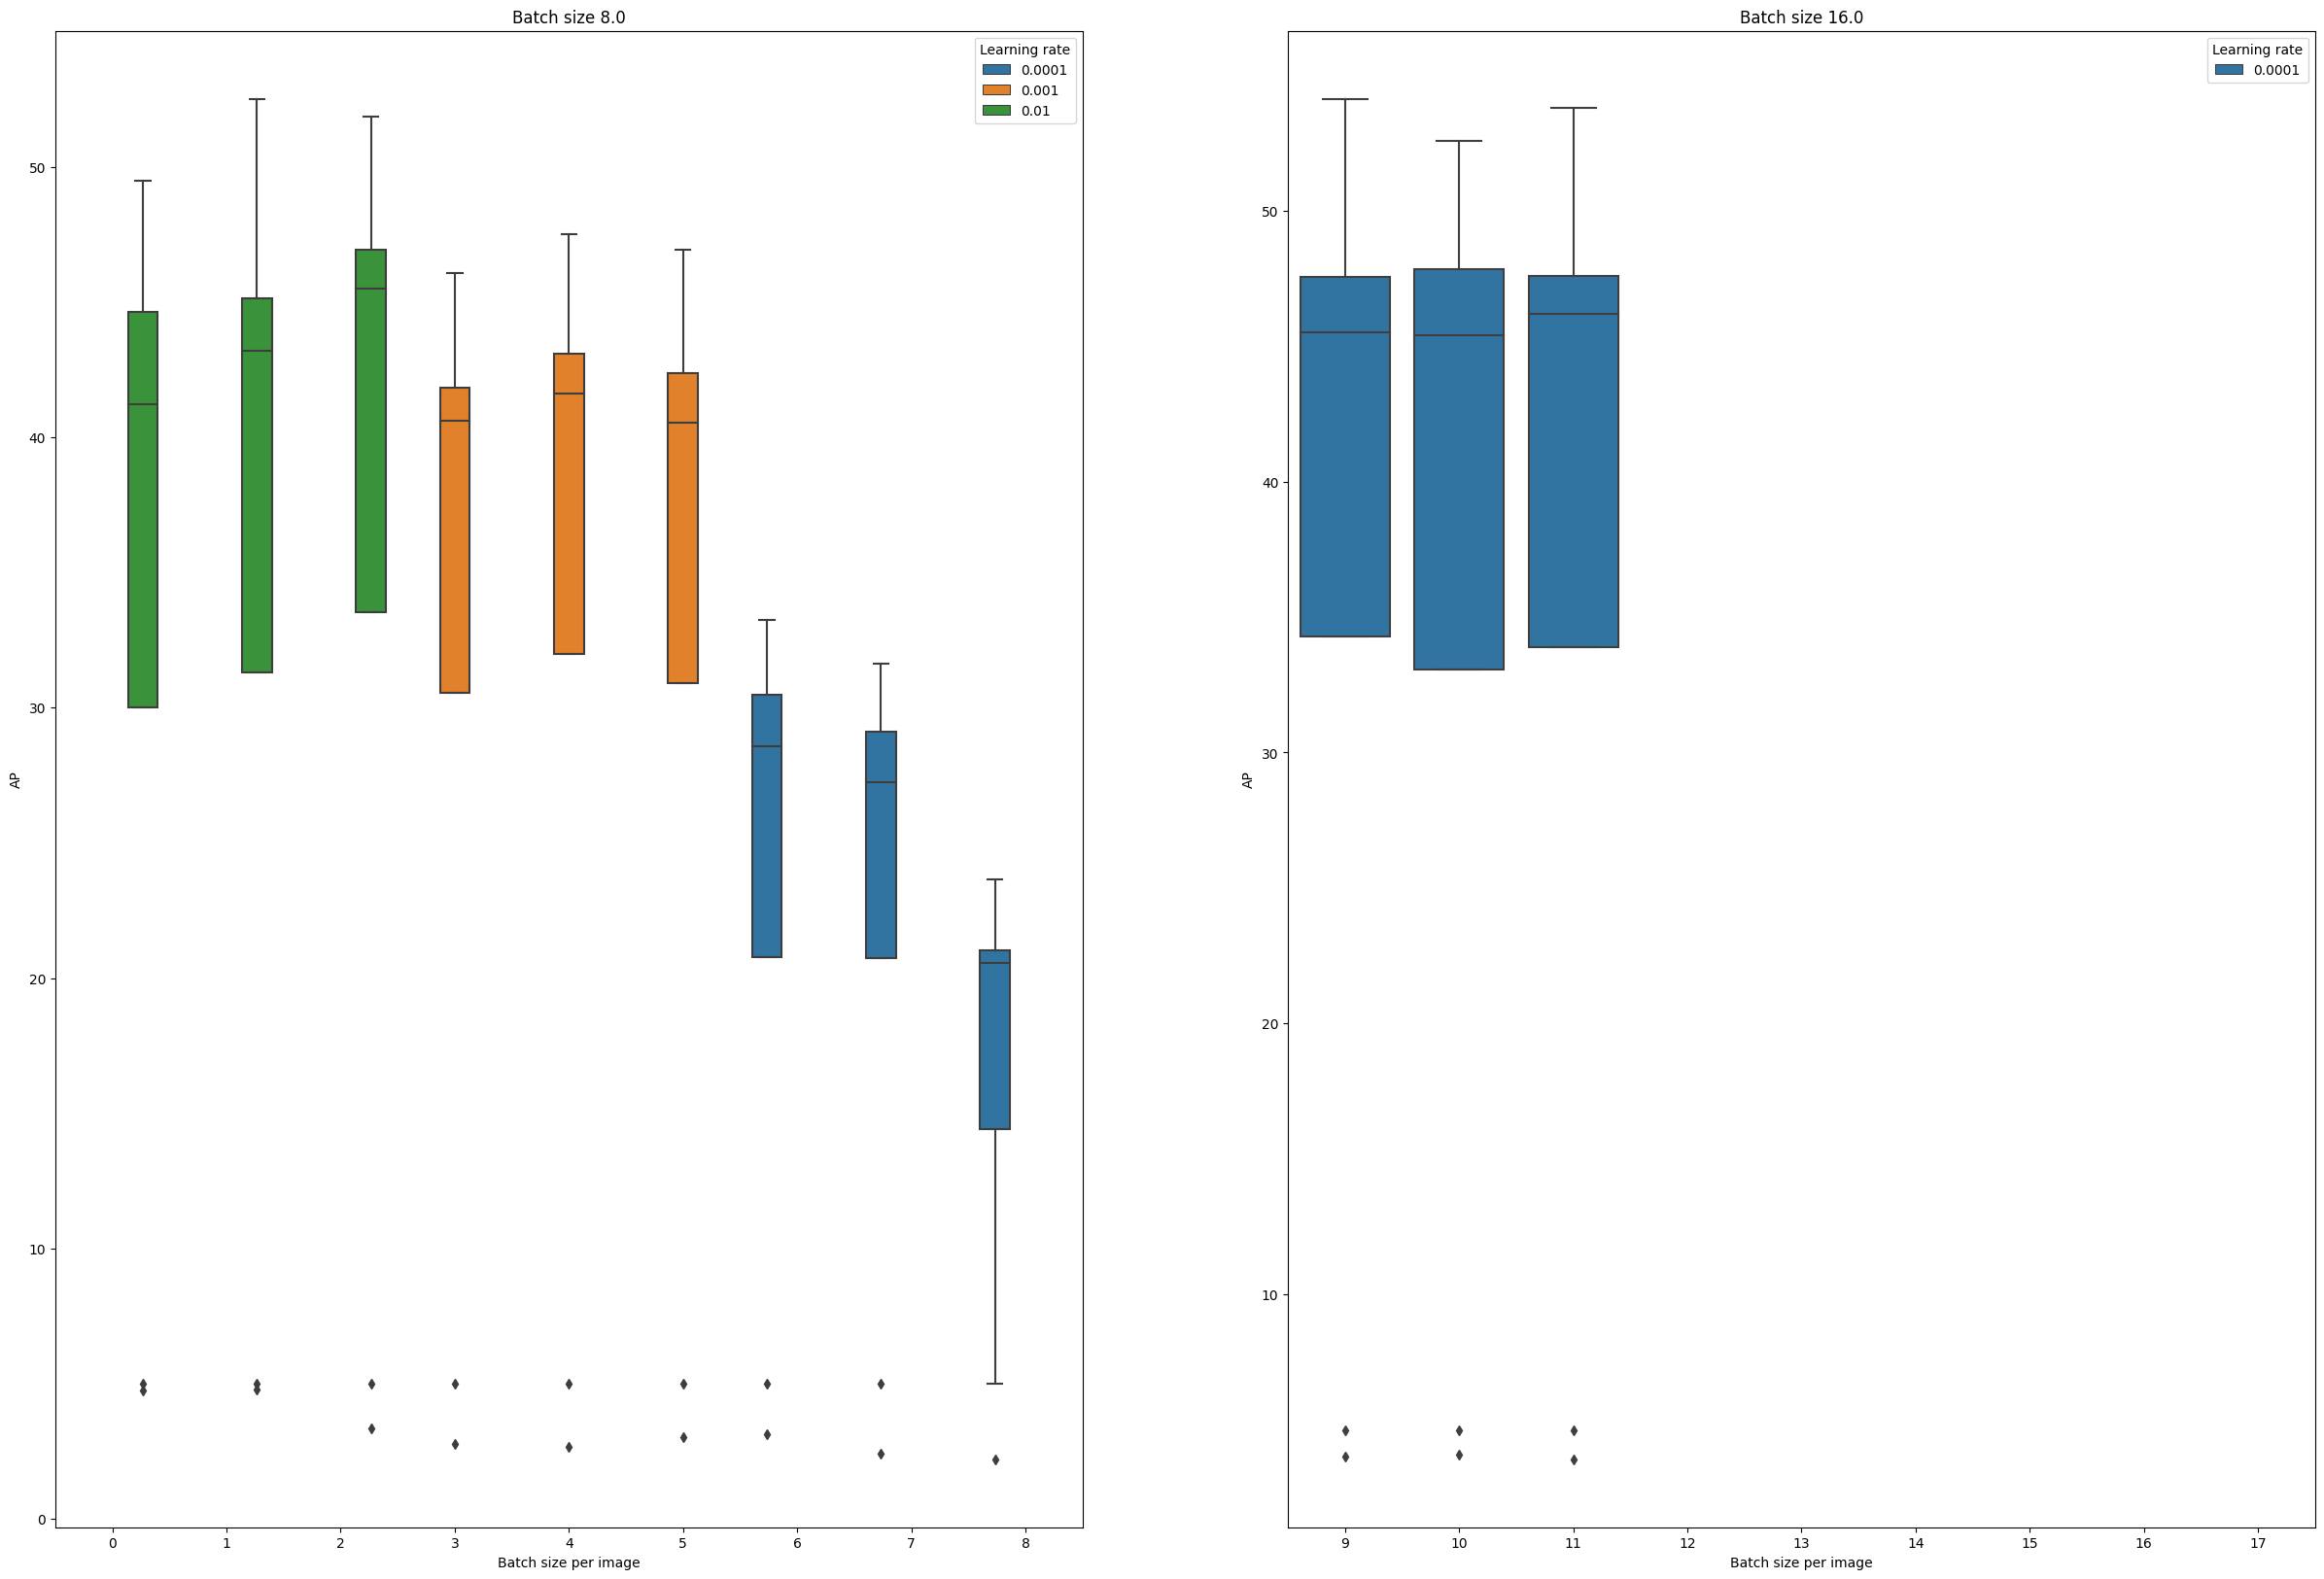

In [119]:
x_value = [128, 256, 512] * 2
x_values_df = pd.DataFrame(x_value, columns=['Batch size per image'])

hue_labels = [0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.0001, 0.0001, 0.0001]

fig, ax = plt.subplots(1, 2, figsize=(30, 20))

melt_bbox_0_11 = grouped_bbox_data_0_11.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_0_11['Learning rate'] = melt_bbox_0_11['OuterKey'].map(dict(enumerate(hue_labels)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_0_11, hue='Learning rate', ax=ax[0])
#ax[0].set_xticklabels(x_values_df['Batch size per image'])
ax[0].set_xlabel('Batch size per image')
ax[0].set_ylabel('AP')
ax[0].set_title('Batch size 8.0')

melt_bbox_12_23 = grouped_bbox_data_12_23.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_bbox_12_23['Learning rate'] = melt_bbox_12_23['OuterKey'].map(dict(enumerate(hue_labels, start=3)))
sns.boxplot(x='OuterKey', y='Value', data=melt_bbox_12_23, hue='Learning rate', ax=ax[1])
ax[1].set_title('Batch size 16.0')
#ax[1].set_xticklabels(x_values_df['Batch size per image'])
ax[1].set_xlabel('Batch size per image')
ax[1].set_ylabel('AP')

plt.show()


In [120]:
grouped_segm_data_0_11 = grouped_data_segm_df[0:9]
grouped_segm_data_12_23 = grouped_data_segm_df[9:18]
print(grouped_segm_data_0_11.shape, grouped_segm_data_12_23.shape)
grouped_segm_data_0_11.head()

(9, 8) (9, 8)


segm_AP_AP                                                        \
              count       mean       std        min        25%        50%   
OuterKey                                                                    
0               5.0  15.390359  2.872120  11.233704  14.291103  15.268353   
1               5.0  15.829881  1.622071  13.105083  15.677423  16.337149   
2               5.0  18.142083  3.444697  12.351533  18.281875  19.029283   
3               5.0  14.897699  2.224738  12.576405  13.176797  14.598387   
4               5.0  14.455119  1.700389  12.231576  13.336069  14.588213   

                                
                75%        max  
OuterKey                        
0         17.948424  18.210212  
1         16.940869  17.088879  
2         19.580239  21.467487  
3         16.085088  18.051816  
4         15.743075  16.376664

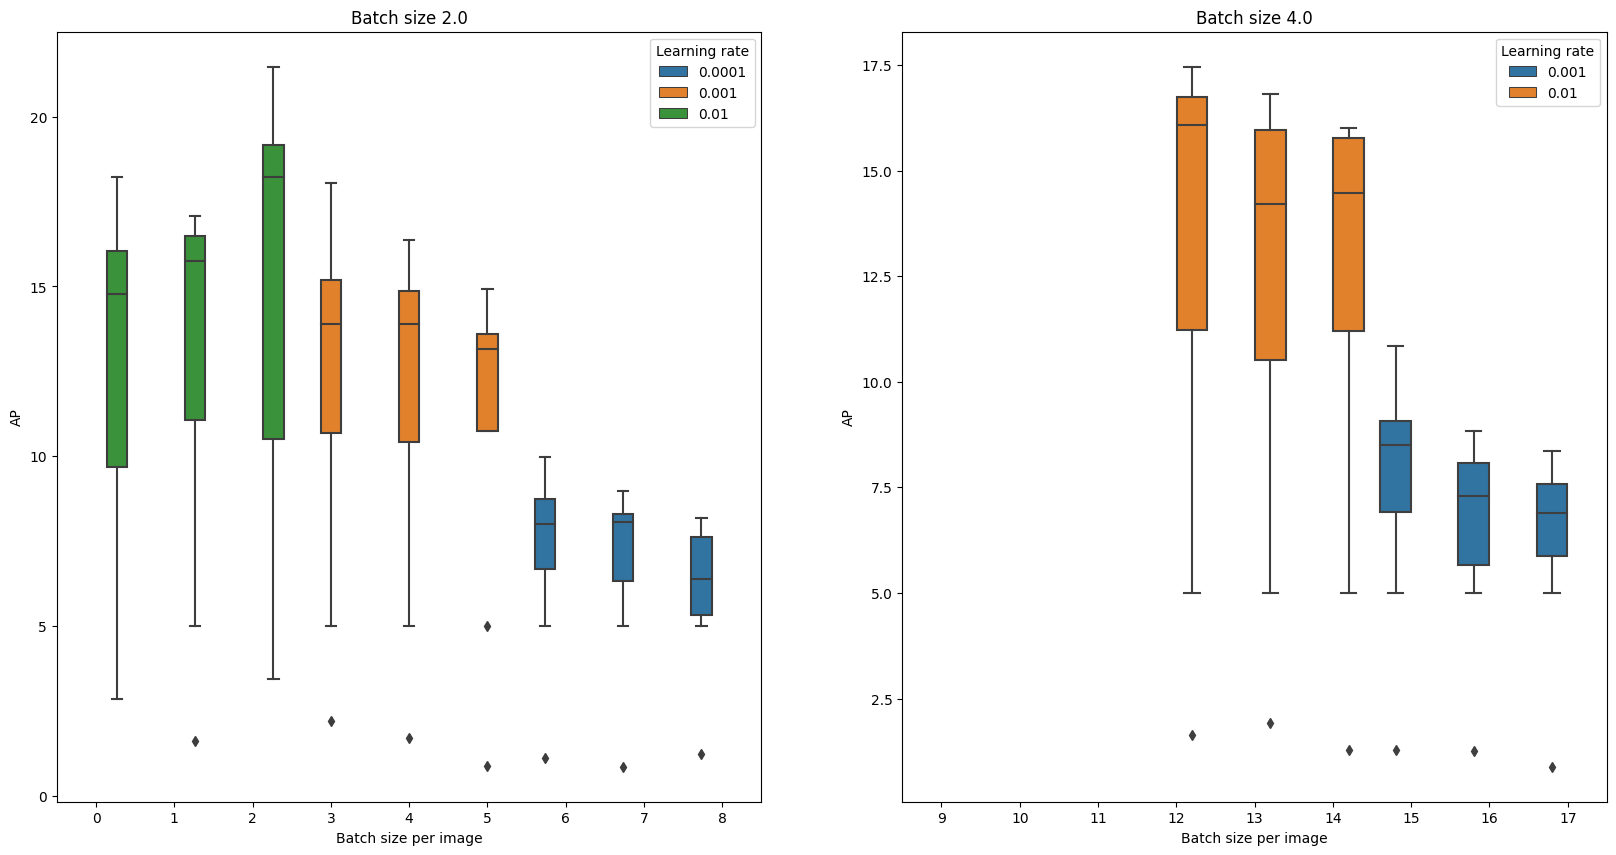

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

melt_segm_0_11 = grouped_segm_data_0_11.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_0_11['Learning rate'] = melt_segm_0_11['OuterKey'].map(dict(enumerate(hue_labels)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_0_11, hue='Learning rate', ax=ax[0])
ax[0].set_xlabel('Batch size per image')
ax[0].set_ylabel('AP')
ax[0].set_title('Batch size 2.0')

melt_segm_12_23 = grouped_segm_data_12_23.reset_index().melt(id_vars=['OuterKey'], var_name='Metric', value_name='Value')
melt_segm_12_23['Learning rate'] = melt_segm_12_23['OuterKey'].map(dict(enumerate(hue_labels, start=12)))
sns.boxplot(x='OuterKey', y='Value', data=melt_segm_12_23, hue='Learning rate', ax=ax[1])
ax[1].set_title('Batch size 4.0')
ax[1].set_xlabel('Batch size per image')
ax[1].set_ylabel('AP')

plt.show()


From the following graphs, we can extract that, as the performance increases, the variance of the results also increases. This is expected in neural networls as they are a high variance model.

# Metrics

In [122]:
import os
import pandas as pd
from tensorflow.python.summary.summary_iterator import summary_iterator

def convert_tb_data(root_dir, sort_by=None):
    def convert_tfevent(filepath):
        return pd.DataFrame([parse_tfevent(e) for e in summary_iterator(filepath) if len(e.summary.value)])

    def parse_tfevent(tfevent):
        return dict(
            wall_time=tfevent.wall_time,
            name=tfevent.summary.value[0].tag,
            step=tfevent.step,
            value=float(tfevent.summary.value[0].simple_value),
        )

    columns_order = ['wall_time', 'name', 'step', 'value']
    out = []
    for (root, _, filenames) in os.walk(root_dir):
        for filename in filenames:
            if "events.out.tfevents" not in filename:
                continue
            file_full_path = os.path.join(root, filename)
            out.append(convert_tfevent(file_full_path))

    # Concatenate (and sort) all partial individual dataframes
    all_df = pd.concat(out)[columns_order]
    if sort_by:
        all_df = all_df.sort_values(by=sort_by)
    return all_df


In [123]:
best_model_name_one = "bs_16_lr_0.01_bsi_512"
model_38_0 = convert_tb_data(f"./../models/Glass_models/{best_model_name_one}/0")
model_38_1 = convert_tb_data(f"./../models/Glass_models/{best_model_name_one}/1")
model_38_2 = convert_tb_data(f"./../models/Glass_models/{best_model_name_one}/2")
model_38_3 = convert_tb_data(f"./../models/Glass_models/{best_model_name_one}/3")
model_38_4 = convert_tb_data(f"./../models/Glass_models/{best_model_name_one}/4")
model_38_0.head()

ValueError: No objects to concatenate

In [ ]:
best_model_name_two = "bs_16_lr_0.01_bsi_256"

model_50_0 = convert_tb_data(f"./../models/Glass_models/{best_model_name_two}/0")
model_50_1 = convert_tb_data(f"./../models/Glass_models/{best_model_name_two}/1")
model_50_2 = convert_tb_data(f"./../models/Glass_models/{best_model_name_two}/2")
model_50_3 = convert_tb_data(f"./../models/Glass_models/{best_model_name_two}/3")
model_50_4 = convert_tb_data(f"./../models/Glass_models/{best_model_name_two}/4")
model_50_0.head()

,wall_time,name,step,value
0,1.732166e+09,data_time,18,0.402425
1,1.732166e+09,rpn/num_pos_anchors,19,7.593750
2,1.732166e+09,rpn/num_neg_anchors,19,248.406250
3,1.732166e+09,roi_head/num_fg_samples,19,8.000000
4,1.732166e+09,roi_head/num_bg_samples,19,120.000000


In [ ]:
model_38_0_metrics = model_38_0.pivot(index='step', columns='name', values='value')
model_38_0_metrics = model_38_0_metrics.dropna(how='all')
model_38_0_metrics_eval = model_38_0_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_1_metrics = model_38_1.pivot(index='step', columns='name', values='value')
model_38_1_metrics = model_38_1_metrics.dropna(how='all')
model_38_1_metrics_eval = model_38_1_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_2_metrics = model_38_2.pivot(index='step', columns='name', values='value')
model_38_2_metrics = model_38_2_metrics.dropna(how='all')
model_38_2_metrics_eval = model_38_2_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_3_metrics = model_38_3.pivot(index='step', columns='name', values='value')
model_38_3_metrics = model_38_3_metrics.dropna(how='all')
model_38_3_metrics_eval = model_38_3_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_4_metrics = model_38_4.pivot(index='step', columns='name', values='value')
model_38_4_metrics = model_38_4_metrics.dropna(how='all')
model_38_4_metrics_eval = model_38_4_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

In [ ]:
model_50_0_metrics = model_50_0.pivot(index='step', columns='name', values='value')
model_50_0_metrics = model_50_0_metrics.dropna(how='all')
model_50_0_metrics_eval = model_50_0_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_50_1_metrics = model_50_1.pivot(index='step', columns='name', values='value')
model_50_1_metrics = model_50_1_metrics.dropna(how='all')
model_50_1_metrics_eval = model_50_1_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_50_2_metrics = model_50_2.pivot(index='step', columns='name', values='value')
model_50_2_metrics = model_50_2_metrics.dropna(how='all')
model_50_2_metrics_eval = model_50_2_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_50_3_metrics = model_50_3.pivot(index='step', columns='name', values='value')
model_50_3_metrics = model_50_3_metrics.dropna(how='all')
model_50_3_metrics_eval = model_50_3_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_50_4_metrics = model_50_4.pivot(index='step', columns='name', values='value')
model_50_4_metrics = model_50_4_metrics.dropna(how='all')
model_50_4_metrics_eval = model_50_4_metrics.dropna(subset=['bbox/AP', 'segm/AP'])

model_38_0_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,9.135859,20.538246,5.012781,10.056663,12.819404,11.023669,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,12.340541,28.103832,7.160355,14.157890,16.502087,13.241258,NaN,1243.344971,0.947754,0.535100,...,247.65625,8.34375,1.891915,6.547446,0.175795,0.000000,8.415882,1.315379,0.899920,0.601171
149,15.545222,35.669418,9.307930,18.259117,20.184769,15.458846,NaN,NaN,NaN,NaN,...,NaN,NaN,3.783830,13.094892,0.351589,0.000000,16.831764,2.630758,NaN,NaN
199,22.244976,41.832790,18.818174,27.702036,28.670242,19.359364,NaN,1159.368896,0.962769,0.233717,...,247.90625,8.09375,6.194314,20.208849,1.064487,1.039604,22.267141,3.639637,0.899179,0.366418
249,28.944731,47.996162,28.328417,37.144951,37.155716,23.259882,NaN,NaN,NaN,NaN,...,NaN,NaN,8.604796,27.322805,1.777385,2.079208,27.702520,4.648517,NaN,NaN


In [ ]:
model_38_avg_metrics = (model_38_0_metrics + model_38_1_metrics + model_38_2_metrics + model_38_3_metrics + model_38_4_metrics) / 5
model_38_avg_metrics_eval = model_38_avg_metrics.dropna(subset=['bbox/AP', 'segm/AP'])
model_38_avg_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,9.346058,21.113481,6.019572,11.085474,14.949724,8.607590,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,13.219127,29.161071,8.566745,15.958472,18.962957,12.014065,NaN,1238.078394,0.949414,0.542088,...,247.79375,8.20625,1.979203,7.091247,0.243706,0.307756,8.211996,1.261085,0.895078,0.571004
149,17.092196,37.208659,11.113918,20.831469,22.976190,15.420539,NaN,NaN,NaN,NaN,...,NaN,NaN,3.958406,14.182494,0.485646,0.615512,16.423991,2.522171,NaN,NaN
199,22.518664,41.664847,20.465875,26.624382,29.799579,19.110861,NaN,1155.056567,0.961694,0.207709,...,248.06875,7.93125,6.086994,20.674061,0.881484,2.064731,20.900954,3.651688,0.899253,0.359993
249,27.945132,46.121034,29.817833,32.417295,36.622970,22.801184,NaN,NaN,NaN,NaN,...,NaN,NaN,8.215582,27.165628,1.179454,3.513951,25.377917,4.781205,NaN,NaN


In [ ]:
model_50_avg_metrics = (model_50_0_metrics + model_50_1_metrics + model_50_2_metrics + model_50_3_metrics + model_50_4_metrics) / 5
model_50_avg_metrics_eval = model_50_avg_metrics.dropna(subset=['bbox/AP', 'segm/AP'])
model_50_avg_metrics_eval.head()

name,bbox/AP,bbox/AP50,bbox/AP75,bbox/APl,bbox/APm,bbox/APs,data_time,eta_seconds,fast_rcnn/cls_accuracy,fast_rcnn/false_negative,...,rpn/num_neg_anchors,rpn/num_pos_anchors,segm/AP,segm/AP50,segm/AP75,segm/APl,segm/APm,segm/APs,time,total_loss
step,,,,,,,,,,,,,,,,,,,,,
49,7.911942,23.269614,2.537601,11.318637,11.105354,7.637254,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
99,14.593754,32.252026,10.467816,19.004593,19.358645,13.030046,NaN,3332.984106,0.923145,0.205255,...,247.49375,8.50625,2.294132,8.337442,0.236122,0.659158,8.627626,1.535076,2.386570,0.763018
149,21.275567,41.234440,18.398030,26.690548,27.611937,18.422838,NaN,NaN,NaN,NaN,...,NaN,NaN,4.588263,16.674883,0.472245,1.308416,17.255252,3.070152,NaN,NaN
199,24.811927,43.403096,25.012753,31.381680,32.672759,20.828415,NaN,3178.252661,0.948193,0.088482,...,248.04375,7.95625,6.310462,21.446510,0.910414,2.480043,21.935895,4.154396,2.611891,0.474269
249,28.348286,45.201300,31.627475,36.072810,37.733582,23.233992,NaN,NaN,NaN,NaN,...,NaN,NaN,8.032660,26.218135,1.348584,3.496125,26.616537,5.238640,NaN,NaN


In [ ]:
model_50_avg_metrics.columns

Index(['bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APl', 'bbox/APm', 'bbox/APs',
       'data_time', 'eta_seconds', 'fast_rcnn/cls_accuracy',
       'fast_rcnn/false_negative', 'fast_rcnn/fg_cls_accuracy', 'loss_box_reg',
       'loss_cls', 'loss_mask', 'loss_rpn_cls', 'loss_rpn_loc', 'lr',
       'mask_rcnn/accuracy', 'mask_rcnn/false_negative',
       'mask_rcnn/false_positive', 'roi_head/num_bg_samples',
       'roi_head/num_fg_samples', 'rpn/num_neg_anchors', 'rpn/num_pos_anchors',
       'segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APl', 'segm/APm', 'segm/APs',
       'time', 'total_loss'],
      dtype='object', name='name')

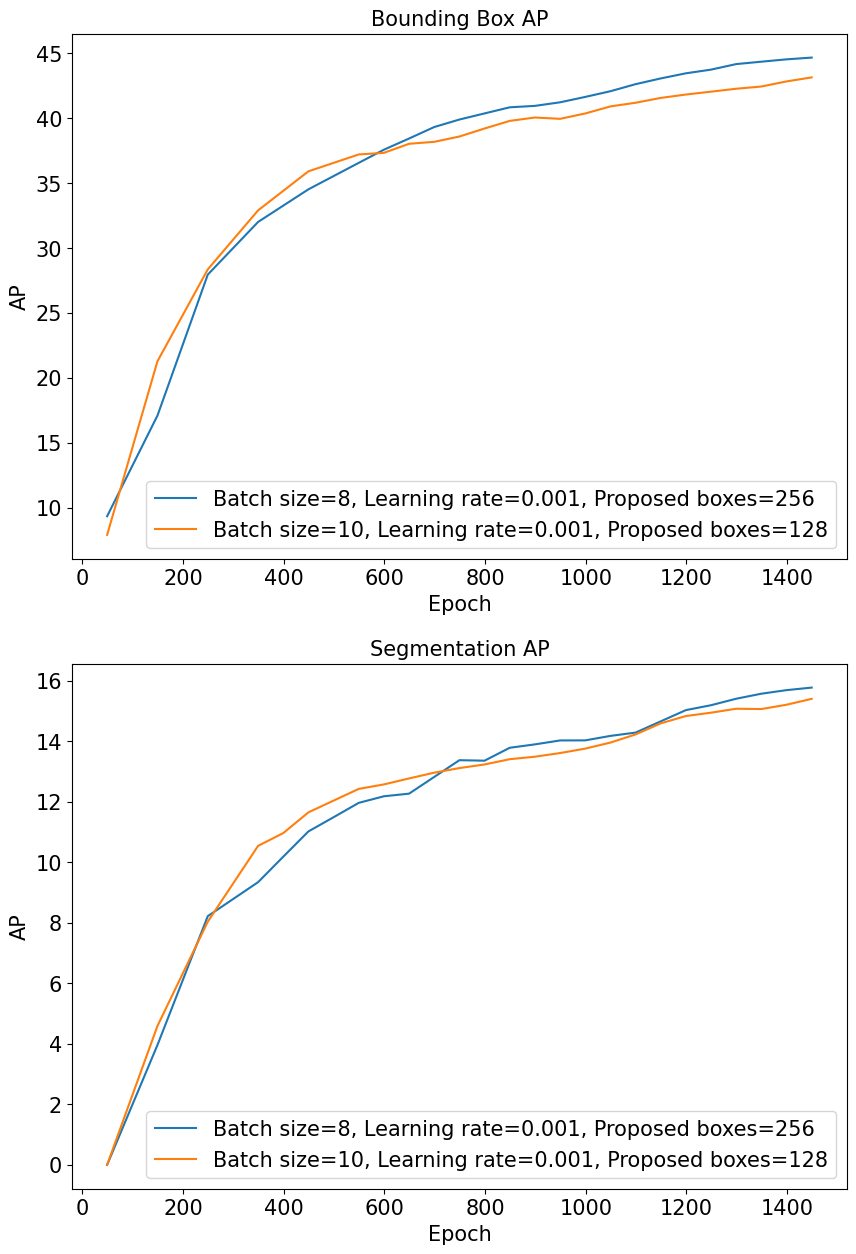

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 15))

model_38_avg_metrics_eval.plot(y='bbox/AP', ax=ax[0], label='Batch size=8, Learning rate=0.001, Proposed boxes=256')
model_50_avg_metrics_eval.plot(y='bbox/AP', ax=ax[0], label='Batch size=10, Learning rate=0.001, Proposed boxes=128')
model_38_avg_metrics_eval.plot(y='segm/AP', ax=ax[1], label='Batch size=8, Learning rate=0.001, Proposed boxes=256')
model_50_avg_metrics_eval.plot(y='segm/AP', ax=ax[1], label='Batch size=10, Learning rate=0.001, Proposed boxes=128')

ax[0].legend(fontsize=15)
ax[0].set_xlabel('Epoch', fontsize=15)
ax[0].set_title('Bounding Box AP', fontsize=15)
ax[0].set_ylabel('AP', fontsize=15)
ax[0].tick_params(axis='both', which='major', labelsize=15)

ax[1].legend(fontsize=15)
ax[1].set_title('Segmentation AP', fontsize=15)
ax[1].set_xlabel('Epoch', fontsize=15)
ax[1].set_ylabel('AP', fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)


plt.show()

Comparing both models when trained up to 5000 epochs, we can observe that in both cases model 38 is the best performing. 

## Overfitting

In [ ]:
model_38_avg_metrics_eval = model_38_avg_metrics_eval.drop(columns=['data_time'])
model_38_avg_metrics_eval = model_38_avg_metrics_eval.dropna()
print(model_38_avg_metrics_eval.head())

name    bbox/AP  bbox/AP50  bbox/AP75   bbox/APl   bbox/APm   bbox/APs  \
step                                                                     
99    13.219127  29.161071   8.566745  15.958472  18.962957  12.014065   
199   22.518664  41.664847  20.465875  26.624382  29.799579  19.110861   
299   29.973395  47.779823  32.954931  35.858198  38.915815  24.545612   
399   33.257017  51.513297  37.120628  41.479622  41.946964  27.317123   
499   35.531290  54.258533  39.990067  44.427672  44.404305  29.251032   

name  eta_seconds  fast_rcnn/cls_accuracy  fast_rcnn/false_negative  \
step                                                                  
99    1238.078394                0.949414                  0.542088   
199   1155.056567                0.961694                  0.207709   
299   1068.294971                0.972949                  0.136248   
399    979.925244                0.975610                  0.119055   
499    891.820349                0.980322              

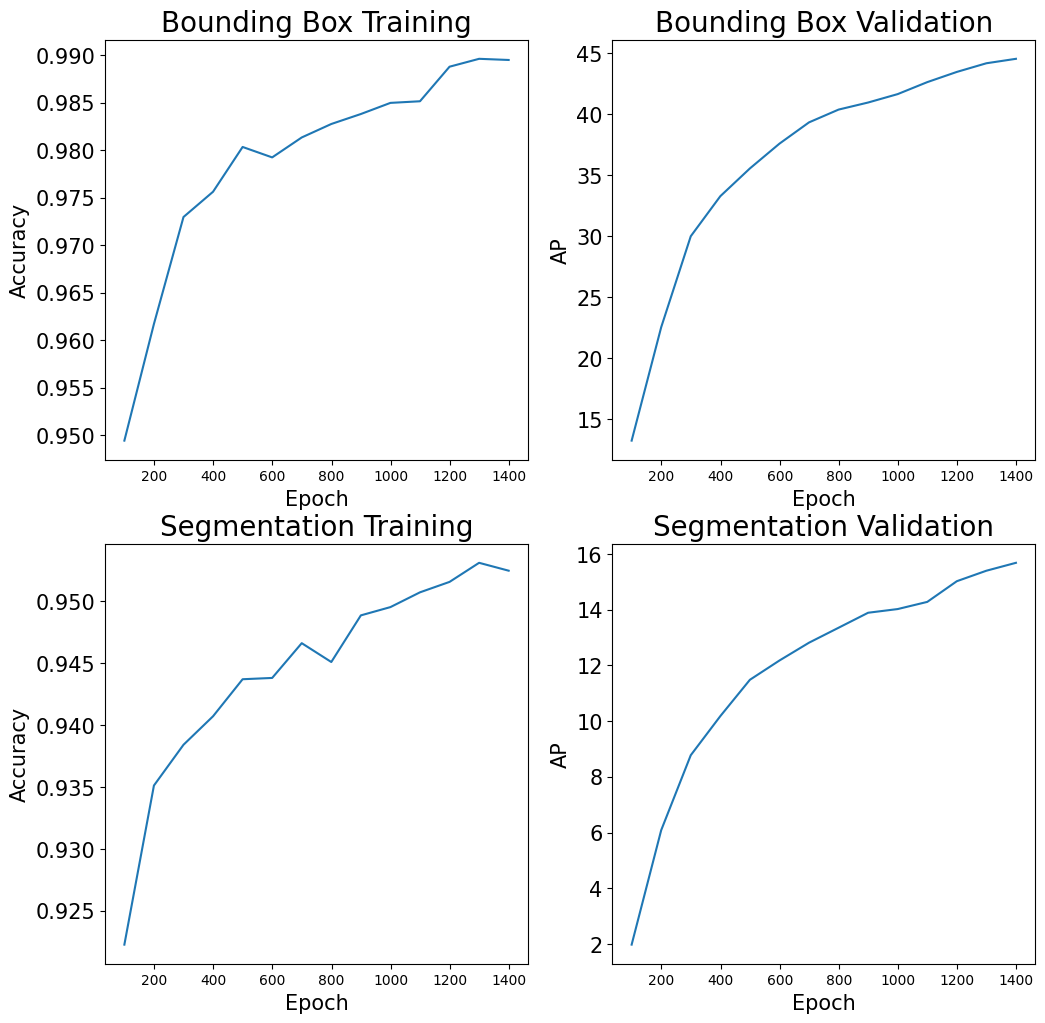

In [ ]:
# Plot the curve of the average of model 50 that compares bbox/AP to fast_rcnn/cls_accuracy and segm/AP to mask_rcnn/accuracy, set log scale on the y-axis
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

model_38_avg_metrics_eval.plot(y='bbox/AP', ax=ax[0][1], legend=False)
model_38_avg_metrics_eval.plot(y='fast_rcnn/cls_accuracy', ax=ax[0][0], legend=False)

model_38_avg_metrics_eval.plot(y='segm/AP', ax=ax[1][1], legend=False)
model_38_avg_metrics_eval.plot(y='mask_rcnn/accuracy', ax=ax[1][0], legend=False)

#ax[0][1].legend(fontsize=20)
ax[0][0].set_title('Bounding Box Training', fontsize=20)
ax[0][0].set_xlabel('Epoch', fontsize=15)
ax[0][0].set_ylabel('Accuracy', fontsize=15)
ax[0][0].tick_params(axis='y', which='both', labelsize=15)

#ax[0][0].legend(fontsize=20)
ax[0][1].set_title('Bounding Box Validation', fontsize=20)
ax[0][1].set_xlabel('Epoch', fontsize=15)
ax[0][1].set_ylabel('AP', fontsize=15)
ax[0][1].tick_params(axis='y', which='both', labelsize=15)

#ax[1][1].legend(fontsize=20)
ax[1][0].set_title('Segmentation Training', fontsize=20)
ax[1][0].set_xlabel('Epoch', fontsize=15)
ax[1][0].set_ylabel('Accuracy', fontsize=15)
ax[1][0].tick_params(axis='y', which='both', labelsize=15)

#ax[1][0].legend(fontsize=20)
ax[1][1].set_title('Segmentation Validation', fontsize=20)
ax[1][1].set_xlabel('Epoch', fontsize=15)
ax[1][1].set_ylabel('AP', fontsize=15)
ax[1][1].tick_params(axis='y', which='both', labelsize=15)

plt.show()

From comparing training and evaluation curves, we can clearly see that around epoch 3000 the model starts overfitting as the training loss keeps decreasing while the evaluation loss starts increasing. This means that the final model should be trained up to 3000 epochs.

In [ ]:

final_model_epoch_3000 = model_38_avg_metrics_eval.iloc[-1]
final_model_epoch_3000

name
bbox/AP                       44.517988
bbox/AP50                     66.333839
bbox/AP75                     51.145389
bbox/APl                      54.084683
bbox/APm                      54.891010
bbox/APs                      36.734048
eta_seconds                   90.469159
fast_rcnn/cls_accuracy         0.989478
fast_rcnn/false_negative       0.046831
fast_rcnn/fg_cls_accuracy      0.944142
loss_box_reg                   0.068689
loss_cls                       0.026888
loss_mask                      0.108927
loss_rpn_cls                   0.001294
loss_rpn_loc                   0.007385
lr                             0.010000
mask_rcnn/accuracy             0.952482
mask_rcnn/false_negative       0.142261
mask_rcnn/false_positive       0.027942
roi_head/num_bg_samples      234.625000
roi_head/num_fg_samples       21.375000
rpn/num_neg_anchors          247.875000
rpn/num_pos_anchors            8.125000
segm/AP                       15.681812
segm/AP50                     47.04

/tmp/ipykernel_624012/664442331.py:22: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(25)


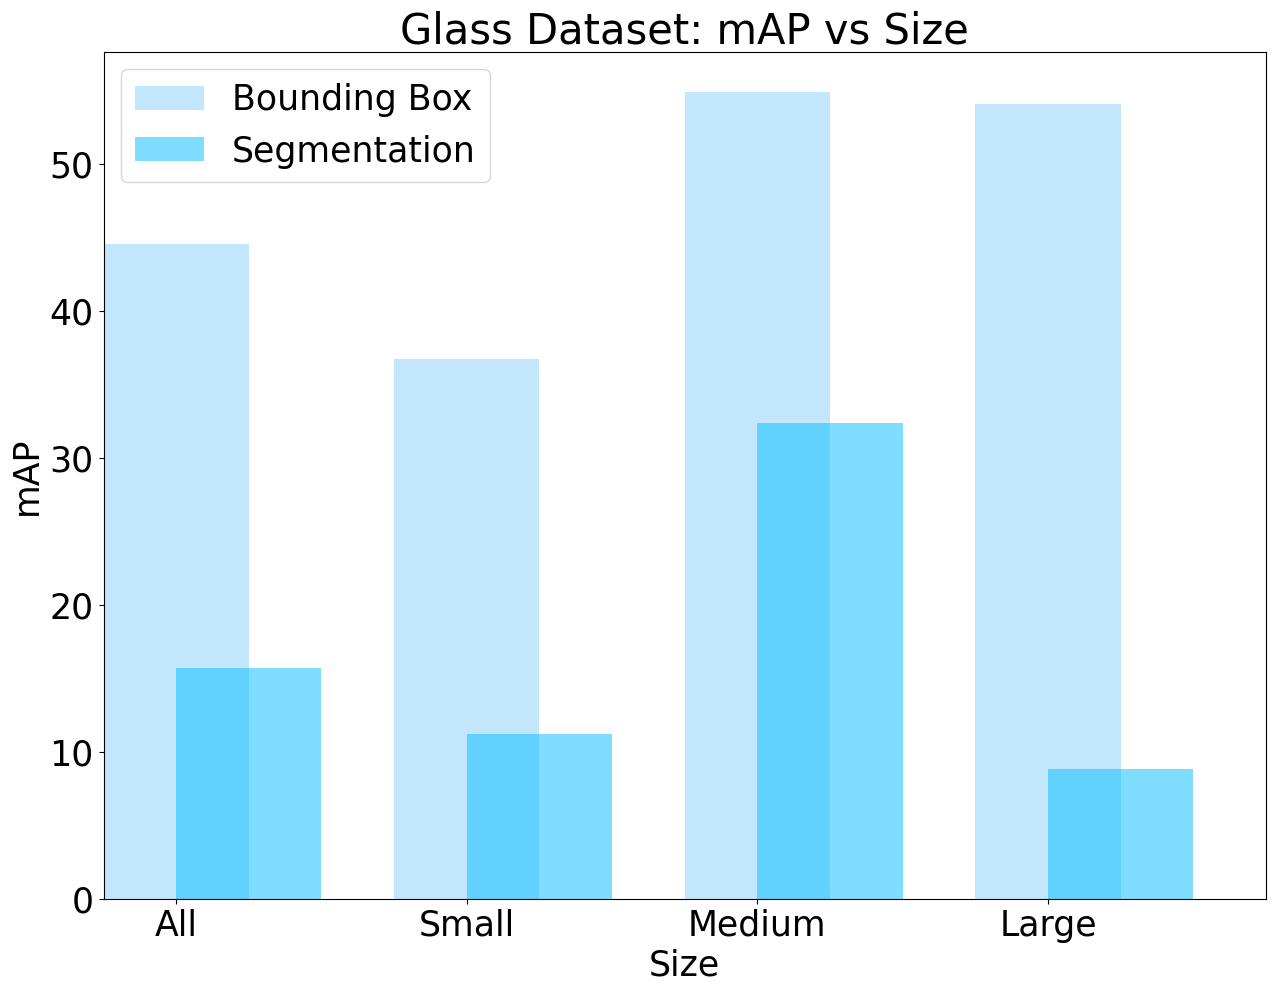

In [124]:
# Bar plot for the final model at epoch 3500
fig, ax = plt.subplots(1, 1, figsize=(15, 11))

#final_model_epoch_3000[['bbox/AP', 'bbox/AP50', 'bbox/AP75', 'bbox/APs', 'bbox/APm', 'bbox/APl', 'segm/AP', 'segm/AP50', 'segm/AP75', 'segm/APs', 'segm/APm', 'segm/APl']].plot(kind='bar', ax=ax)

bbox_metrics = ['bbox/AP', 'bbox/APs', 'bbox/APm', 'bbox/APl']
segm_metrics = ['segm/AP', 'segm/APs', 'segm/APm', 'segm/APl']
# Plotting bbox metrics

final_model_epoch_3000[bbox_metrics].plot(kind='bar', ax=ax, alpha=0.5, label= "Bounding Box", color='lightskyblue', position=0.5)

# Plotting segm metrics
final_model_epoch_3000[segm_metrics].plot(kind='bar', ax=ax, alpha=0.5, label= "Segmentation", color='deepskyblue', position=0)

ax.legend(fontsize=25)
ax.set_title('Glass Dataset: mAP vs Size', fontsize=30)
ax.set_ylabel('mAP', fontsize=25)
ax.set_xlabel('Size', fontsize=25)

# Set font size for y-axis tick labels
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(25)

#Change x-axis labels
ax.set_xticklabels(['All', 'Small', 'Medium', 'Large'], rotation=0, fontsize=25)


plt.show()

In [ ]:
# Show a table for the IoU values and the AP values for the final model at epoch 3500
#final_model_epoch_3000[['bbox/AP50', 'bbox/AP75', 'segm/AP50', 'segm/AP75']]



name
bbox/AP50    14.829089
bbox/AP75    11.249963
segm/AP50     9.147080
segm/AP75     0.674833
Name: 2999, dtype: float64

In [ ]:
unet_segm_results = [3, 2, 2]
unet_bbox_results = [10, 9, 5]

In [ ]:
# Create a DataFrame for the new data
additional_data = {
    'Metric': ['Overall', 'IoU 0.5', 'IoU 0.75'],
    'unet_bbox': unet_bbox_results,
    'unet_segm': unet_segm_results,
}
additional_df = pd.DataFrame(additional_data)

/tmp/ipykernel_624012/1959022152.py:31: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(27)


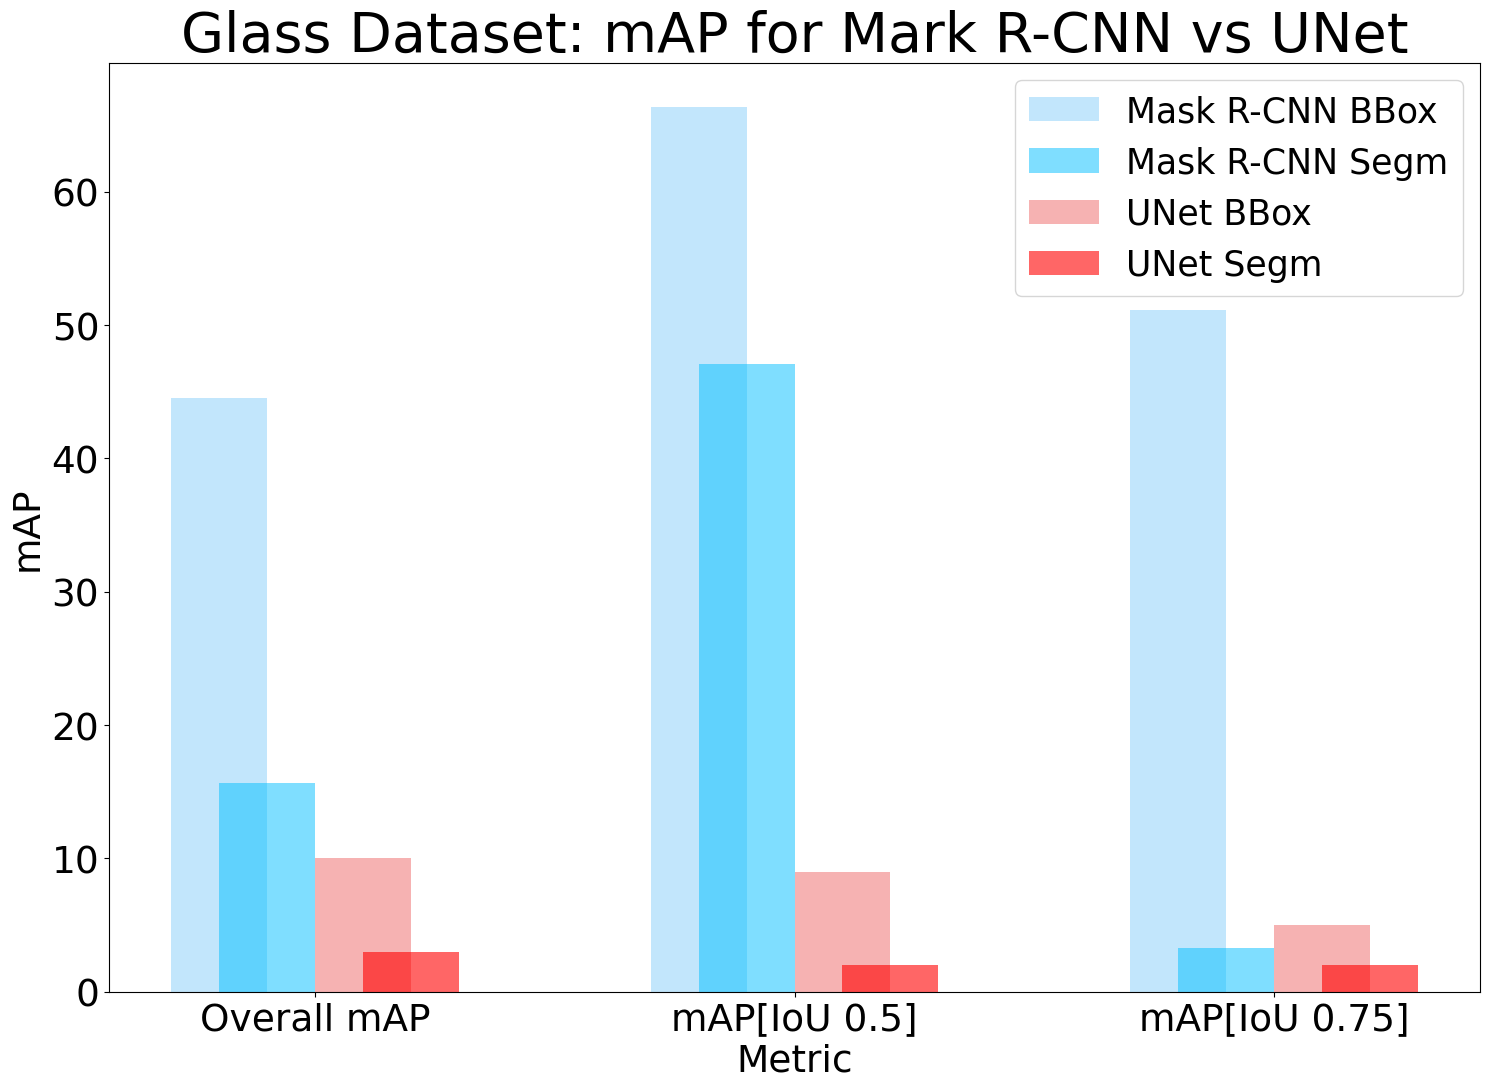

In [ ]:
bbox_metrics = ['bbox/AP', 'bbox/AP50', 'bbox/AP75']
segm_metrics = ['segm/AP', 'segm/AP50', 'segm/AP75']

x_labels = ['Overall mAP', 'mAP[IoU 0.5]', 'mAP[IoU 0.75]']
# Initialize the plot
fig, ax = plt.subplots(figsize=(15, 11))

# Set bar width and positions
bar_width = 0.2
index = np.arange(len(x_labels))

# Plotting Final Model Metrics
ax.bar(index - 0.5*bar_width, final_model_epoch_3000[bbox_metrics].values.flatten(), bar_width,
       alpha=0.5, label='Mask R-CNN BBox', color='lightskyblue')
ax.bar(index, final_model_epoch_3000[segm_metrics].values.flatten(), bar_width,
       alpha=0.5, label='Mask R-CNN Segm', color='deepskyblue')

# Plotting UNet Metrics
ax.bar(index + bar_width, unet_bbox_results, bar_width,
       alpha=0.6, label='UNet BBox', color='lightcoral')
ax.bar(index + 1.5*bar_width, unet_segm_results, bar_width,
       alpha=0.6, label='UNet Segm', color='red')

# Customize the plot
ax.set_title('Glass Dataset: mAP for Mark R-CNN vs UNet', fontsize=40)
ax.set_ylabel('mAP', fontsize=27)
ax.set_xlabel('Metric', fontsize=27)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(x_labels, rotation=0, fontsize=27)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(27)

ax.legend(fontsize=25)

# Show the plot
plt.tight_layout()
plt.show()


# Final model

For our final model we will use the following hyperparameters: bs=8.0, lr=0.001, bspi=256 and 3000 epochs traiend on all data.

In [ ]:
final_model = convert_tb_data("./../models/Glass_models/38_3000")
final_model.head()

ValueError: No objects to concatenate

In [ ]:
final_model_metrics = final_model.pivot(index='step', columns='name', values='value')
final_model_metrics = final_model_metrics.drop(columns=['data_time'])
final_model_metrics = final_model_metrics.dropna(how='all') 
final_model_metrics.head()

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(10, 10))

final_model_metrics.plot(y='loss_cls', ax=ax[0][0], label='loss_cls')
final_model_metrics.plot(y='loss_mask', ax=ax[0][1], label='loss_mask')
final_model_metrics.plot(y='loss_rpn_cls', ax=ax[1][0], label='loss_rpn_cls')
final_model_metrics.plot(y='loss_rpn_loc', ax=ax[1][1], label='loss_rpn_loc')
final_model_metrics.plot(y='loss_box_reg', ax=ax[2][0], label='loss_box_reg')
final_model_metrics.plot(y='total_loss', ax=ax[2][1], label='total_loss')


In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

final_model_metrics.plot(y='mask_rcnn/accuracy', ax=ax[0], label='mask_rcnn/accuracy')
final_model_metrics.plot(y='fast_rcnn/cls_accuracy', ax=ax[1], label='fast_rcnn/cls_accuracy')

plt.show()